## Softmax Regression Extra credit and Plot confusion matrix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set, onehot_encode, onehot_decode, z_score_normalize, append_bias
from model.softmax import SoftmaxRegression

In [2]:
### Q6(a) - Evaluate Network on all 43 traffic signs (aligned dataset)

# Load aligned data
X, y = traffic_sign(True)
X = X.astype(np.float32) # cast to float32 as float64 running out of memory
X = z_score_normalize(X) 

print(X.shape)
print(y.shape)
print(X.dtype)
print(y.dtype)

(34799, 1024)
(34799,)
float32
uint8


With PCA on unaligned
Current Fold: 0


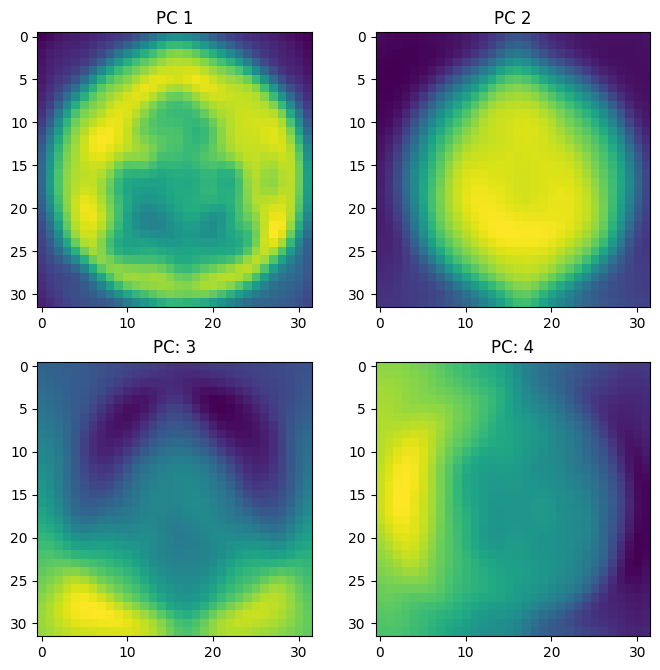

(27841, 300)
(3479, 300)
(3479, 300)
 epoch: 50, train accuracy: 0.6265, train_loss_norm:0.0466, valid_acc: 0.6005, valid_loss_norm: 0.1070
 epoch: 100, train accuracy: 0.6558, train_loss_norm:0.0392, valid_acc: 0.6189, valid_loss_norm: 0.1020
 epoch: 150, train accuracy: 0.6748, train_loss_norm:0.0359, valid_acc: 0.6306, valid_loss_norm: 0.0989
 epoch: 200, train accuracy: 0.6886, train_loss_norm:0.0339, valid_acc: 0.6378, valid_loss_norm: 0.0970
 epoch: 250, train accuracy: 0.6985, train_loss_norm:0.0325, valid_acc: 0.6433, valid_loss_norm: 0.0955
 epoch: 300, train accuracy: 0.7063, train_loss_norm:0.0315, valid_acc: 0.6467, valid_loss_norm: 0.0946
Test accuracy: 0.6450
Test loss norm: 0.0950
Current Fold: 1
(27841, 300)
(3479, 300)
(3479, 300)
 epoch: 50, train accuracy: 0.6276, train_loss_norm:0.0464, valid_acc: 0.5970, valid_loss_norm: 0.1079
 epoch: 100, train accuracy: 0.6572, train_loss_norm:0.0391, valid_acc: 0.6186, valid_loss_norm: 0.1021
 epoch: 150, train accuracy: 0.6781

In [3]:
#%%
## 2. With PCA on unaligned

print("With PCA on unaligned")

# Load unaligned data
X, y = traffic_sign(False)
X = X.astype(np.float32) # cast to float32 as float64 running out of memory
X = z_score_normalize(X) 

DEBUG = False

# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record = []

train_accuracy_record = []

holdout_loss_record = []

holdout_accuracy_record = []

test_accuracy_record = []

# PCA number of principal components
n_components = 300

first_plot = True

num_epochs = 300
epochs_print = [50, 100, 150, 200, 250, 300]

k = 10

total_test_accuracy = 0.0
total_test_loss = 0.0

cur_fold = 0
for train, valid, test in generate_k_fold_set((X, y), k):
    print(f"Current Fold: {cur_fold}")
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data) # len(train_data) x n_components
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = append_bias(projected)     
    valid_d = append_bias(pca.PCA_generate(valid_data))
    test_d = append_bias(pca.PCA_generate(test_data))

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)
    best_w = softmax_model.W

    # Onehot encode labels
    y_true = onehot_encode(train_label)
    valid_label_onehot = onehot_encode(valid_label)
    test_label_onehot = onehot_encode(test_label)
    
    for epoch in range(num_epochs):
        y_hat = softmax_model.model(train_d)
        
        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_norm = raw_train_loss / len(train_d) / num_classes # train loss normalized by # examples and classes
        
        train_loss_record.append(train_loss_norm)
        
        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        holdout_y = softmax_model.model(valid_d)

        holdout_loss = softmax_model.cross_entropy(holdout_y, valid_label_onehot)
        holdout_loss_norm = holdout_loss / len(valid_d) / num_classes # holdout loss normalized by # examples and classes
        holdout_loss_record.append(holdout_loss_norm)

        holdout_accuracy = softmax_model.accuracy(holdout_y, valid_label_onehot)
        holdout_accuracy_record.append(holdout_accuracy)

        if holdout_accuracy >= max(holdout_accuracy_record[cur_fold * num_epochs:]):
            best_w = softmax_model.W

        # Update Weights
        softmax_model.update_weights(train_d, y_true, y_hat)

        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy:.4f}, train_loss_norm:{train_loss_norm:.4f}, '                f'valid_acc: {holdout_accuracy:.4f}, valid_loss_norm: {holdout_loss_norm:.4f}')

    # Run on Test Dataset
    test_y = softmax_model.model_w(test_d, best_w)

    test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)

    print(f'Test accuracy: {test_accuracy:.4f}')

    test_accuracy_record.append(test_accuracy)

    raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
    test_loss_norm = raw_test_loss / len(test_d) / num_classes
    total_test_loss += test_loss_norm
    print(f"Test loss norm: {test_loss_norm:.4f}")

    cur_fold += 1

print(f'Average test accuracy over {k} folds: {np.mean(test_accuracy_record):.4f} (+/- {np.std(test_accuracy_record):.4f})')
print(f'Average test loss per example and class over {k} folds: {total_test_loss / k}')


In [16]:
##confusion Matrix plot

Text(111.5, 0.5, 'pred')

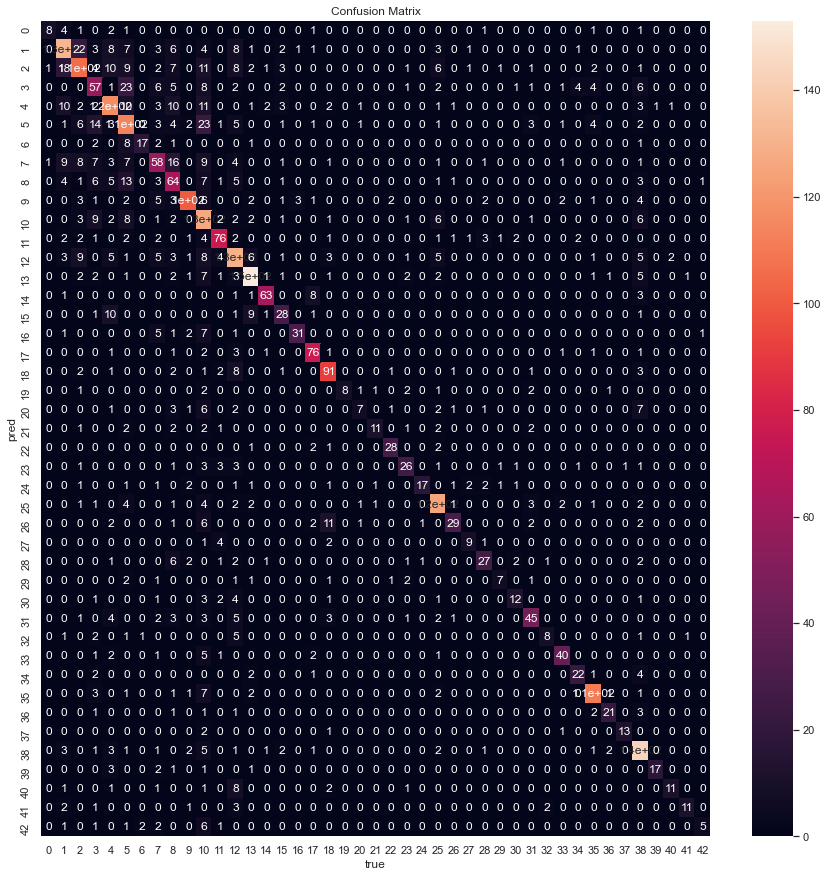

In [23]:
import seaborn as sb
def ConfusionMatrix(true,pred):
    Map=np.zeros((43,43)) # matrix set
    for x, y in zip(true,pred): # add data to matrix
        Map[x][y] += 1
    return Map

label = []
pred = []
label = list(np.argmax(test_label_onehot,axis = 1)) # real data list up
pred = list(np.argmax(test_y,axis = 1)) # pred data list up

M = ConfusionMatrix(label, pred)
sb.set()
f,ax=plt.subplots(figsize=(15,15))
sb.heatmap(M,annot=True,ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('true')
ax.set_ylabel('pred')

In [24]:
#extra credit


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set,generate_no_fold_set, onehot_encode,onehot_decode,z_score_normalize,select_binarydata
from model.logistic import LogisticRegression

#unlined dataset - pca looks pretty bad.
#change data only for 100km/h(class7) and 120km/h(class8)
n_components = 100
X,Y = traffic_sign(True) # check true and false
#data normalize
train_data_normalized = X.astype(np.float32) # cast to float32 as float64 running out of memory
train_data_normalized = z_score_normalize(train_data_normalized) 
load_data = train_data_normalized, Y
#data normalize

def balance_data(dataset):
    Data, labels = dataset
    #top 6 image sets drop -> lowest 6 image sets duplicate
    D = np.copy(Data)
    L = np.copy(labels)
    selectTop = 10
    selectLow = 20

    cnt_array = np.bincount(labels)
    
    # sort. higher data remove, find top 5 
    top5 = (cnt_array.argsort()[-selectTop:][::-1])
    for i in range(np.size(top5)):
        # 5 higher data remove 5%, 5 lowest data duplicate
        idx_high = np.where(labels == top5[i])
        k = np.array(idx_high)[0,1:np.size(idx_high)//5] 
        Data = np.delete(Data,  k,0)
        labels = np.delete(labels,  k,0)
      
    # sort. higher data remove, find top 5 
    
    low5 = (cnt_array.argsort()[1:selectLow+1][::-1])


    for i in range(np.size(low5)):
        # 5 higher data remove 5%, 5 lowest data duplicate
        idx_low = np.where(labels == low5[i])
        k = np.array(idx_low)[0,1:np.size(idx_low)//1]
        Data = np.concatenate([Data,  Data[k]])
        labels = np.concatenate([labels[:], labels[k]])    
    
    cnt_array_balance = np.bincount(labels)
   
    return   Data, labels


def balance_data_plot(dataset):
    Data, labels = dataset
    #top 6 image sets drop -> lowest 6 image sets duplicate
    #permutation    
    
    D = np.copy(Data)
    L = np.copy(labels)
    selectTop = 10
    selectLow = 24
    selectLows = 5

    cnt_array = np.bincount(labels)
    
    # sort. higher data remove, find top 5 
    top5 = (cnt_array.argsort()[-selectTop:][::-1])
    for i in range(np.size(top5)):
        # 5 higher data remove ?% 5 lowest data duplicate ?%
        idx_high = np.where(labels == top5[i])
        # random pick with in range
        randsize = np.size(idx_high)//4
        rand = random.sample(range(randsize), randsize)
        
        
        k = np.array(idx_high)[0,rand] 
        Data = np.delete(Data,  k,0)
        labels = np.delete(labels,  k,0)
      
    # sort. higher data remove, find top 5 
    
    low5 = (cnt_array.argsort()[1:selectLow+1][::-1])

    for i in range(np.size(low5)):
        # 5 higher data remove 5%, 5 lowest data duplicate
        idx_low = np.where(labels == low5[i])
        k = np.array(idx_low)[0,1:np.size(idx_low)//1]
        Data = np.concatenate([Data,  Data[k]])
        labels = np.concatenate([labels[:], labels[k]])    
        
    low5 = (cnt_array.argsort()[1:selectLows+1][::-1])

    for i in range(np.size(low5)):
        # 5 higher data remove 5%, 5 lowest data duplicate
        idx_low = np.where(labels == low5[i])
        k = np.array(idx_low)[0,1:np.size(idx_low)//2]
        Data = np.concatenate([Data,  Data[k]])
        labels = np.concatenate([labels[:], labels[k]])    
            
    
    cnt_array_balance = np.bincount(labels)
   
    return   cnt_array, cnt_array_balance


origin, new = balance_data_plot(load_data)

fig, axs = plt.subplots(1, 1, constrained_layout=True)
fig.set_size_inches(12, 8)
k = np.arange(1,43)

axs.bar(k,origin[k],color = 'b',label = 'origin data',width = 0.3)
axs.bar(k+0.3,new[k],color = 'r',label = 'balanced data',width = 0.3)
axs.legend();
axs.set_xticks(k)
axs.set_xlabel('class')
axs.set_ylabel('numbers')
axs.set_title('Dataset')

plt.show()




In [ ]:
#softmax algorithm trial

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set, onehot_encode, onehot_decode, z_score_normalize, append_bias
from model.softmax import SoftmaxRegression

### Q6(a) - Evaluate Network on all 43 traffic signs (aligned dataset)

# Load aligned data
X, y = traffic_sign(True)
X = X.astype(np.float32) # cast to float32 as float64 running out of memory
X = z_score_normalize(X) 

load_data = X, y

X, y = balance_data(load_data)

## (i) With PCA on aligned

DEBUG = False

# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record = []

train_accuracy_record = []

holdout_loss_record = []

holdout_accuracy_record = []

test_accuracy_record = []

# PCA number of principal components
n_components = 300

first_plot = True

num_epochs = 300
epochs_print = [50, 100, 150, 200, 250, 300]

k = 10

total_test_accuracy = 0.0
total_test_loss = 0.0

cur_fold = 0
for train, valid, test in generate_k_fold_set((X, y), k):
    print(f"Current Fold: {cur_fold}")
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data) # len(train_data) x n_components
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = append_bias(projected)     
    valid_d = append_bias(pca.PCA_generate(valid_data))
    test_d = append_bias(pca.PCA_generate(test_data))

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)
    best_w = softmax_model.W

    # Onehot encode labels
    y_true = onehot_encode(train_label)
    valid_label_onehot = onehot_encode(valid_label)
    test_label_onehot = onehot_encode(test_label)
    
    for epoch in range(num_epochs):
        y_hat = softmax_model.model(train_d)
        
        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_norm = raw_train_loss / len(train_d) / num_classes # train loss normalized by # examples and classes
        
        train_loss_record.append(train_loss_norm)
        
        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        holdout_y = softmax_model.model(valid_d)

        holdout_loss = softmax_model.cross_entropy(holdout_y, valid_label_onehot)
        holdout_loss_norm = holdout_loss / len(valid_d) / num_classes # holdout loss normalized by # examples and classes
        holdout_loss_record.append(holdout_loss_norm)

        holdout_accuracy = softmax_model.accuracy(holdout_y, valid_label_onehot)
        holdout_accuracy_record.append(holdout_accuracy)

        if holdout_accuracy >= max(holdout_accuracy_record[cur_fold * num_epochs:]):
            best_w = softmax_model.W

        # Update Weights
        softmax_model.update_weights(train_d, y_true, y_hat)

        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy:.4f}, train_loss_norm:{train_loss_norm:.4f}, '\
                f'valid_acc: {holdout_accuracy:.4f}, valid_loss_norm: {holdout_loss_norm:.4f}')
            if DEBUG:
                test_y = softmax_model.model_w(test_d, best_w)
                test_y_1 = softmax_model.model(test_d)

                test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)
                test_accuracy_1 = softmax_model.accuracy(test_y_1, test_label_onehot)

                raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
                test_loss_norm = raw_test_loss / len(test_d) / num_classes

                print(f'MODEL_W: Test accuracy: {test_accuracy:.4f}', f'Test loss norm: {test_loss_norm:.4f}')
                print(f'MODEL: Test accuracy: {test_accuracy_1:.4f}')

    # Run on Test Dataset
    test_y = softmax_model.model_w(test_d, best_w)

    test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)

    print(f'Test accuracy: {test_accuracy:.4f}')

    test_accuracy_record.append(test_accuracy)

    raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
    test_loss_norm = raw_test_loss / len(test_d) / num_classes
    total_test_loss += test_loss_norm
    print(f"Test loss norm: {test_loss_norm:.4f}")

    cur_fold += 1

print(f'Average test accuracy over {k} folds: {np.mean(test_accuracy_record):.4f} (+/- {np.std(test_accuracy_record):.4f})')
print(f'Average test loss per example and class over {k} folds: {total_test_loss / k:.4f}')


In [ ]:
def average_out_data_k(data, k=10):
    total_count = len(data)
    count_per_fold = total_count // k # Assumes cleanly divisble number
    new_data = [0.0 for i in range(count_per_fold)]
    for i in range(k):
        for j in range(count_per_fold):
            new_data[j] += data[i * count_per_fold + j]
    new_data = [d / k for d in new_data]
    return new_data

def get_data_at_epoch_fold(data, epoch, total_num_folds=10):
    # Returns a new list of data points at a specified epoch from all folds
    # data = [fold1....fold10]
    # epoch is 0-indexed
    epoch_per_fold = len(data) // total_num_folds
    new_data = [data[f * (epoch_per_fold) + epoch] for f in range(total_num_folds)]
    return new_data # [epoch n from fold1, epoch n from fold2, ..., epoch n from fold10]

fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.set_size_inches(12, 8)

epochs_error_bar = [50, 100, 150, 200, 250, 300] # 1-indexed
epochs_error_bar_0 = [epoch - 1 for epoch in epochs_error_bar] # 0-indexed

# Plot Loss
average_train_loss = average_out_data_k(train_loss_record)
train_loss_error_bar_y = [average_train_loss[epoch] for epoch in epochs_error_bar_0]
train_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_loss_record, epoch)) for epoch in epochs_error_bar_0]

# For Q6b_ii comparison
batch_average_train_loss = average_train_loss 
batch_average_train_loss_error_bar_y = train_loss_error_bar_y
batch_average_train_loss_error_bar_yerr = train_loss_error_bar_yerr

average_valid_loss = average_out_data_k(holdout_loss_record)
valid_loss_error_bar_y = [average_valid_loss[epoch] for epoch in epochs_error_bar_0]
valid_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_loss_record, epoch)) for epoch in epochs_error_bar_0]

axs[0].plot(average_train_loss, '-b', label='Training loss')
axs[0].errorbar(x=epochs_error_bar_0, y=train_loss_error_bar_y, yerr=train_loss_error_bar_yerr, label='Training loss error', fmt='-b')

axs[0].plot(average_valid_loss, '--r', label='Validation loss')
axs[0].errorbar(x=epochs_error_bar_0, y=valid_loss_error_bar_y, yerr=valid_loss_error_bar_yerr, label='Validation loss error', fmt='--r')

axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Normalized Loss')
axs[0].set_title('Loss normalized per example and class vs. Epochs')

# Plot Accuracy
average_train_acc = average_out_data_k(train_accuracy_record)
train_acc_error_bar_y = [average_train_acc[epoch] for epoch in epochs_error_bar_0]
train_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

average_valid_acc = average_out_data_k(holdout_accuracy_record)
valid_acc_error_bar_y = [average_valid_acc[epoch] for epoch in epochs_error_bar_0]
valid_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

axs[1].plot(average_train_acc, '-b', label='Training accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=train_acc_error_bar_y, yerr=train_acc_error_bar_yerr, label='Training accuracy error', fmt='-b')

axs[1].plot(average_valid_acc, '--r', label='Validation accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=valid_acc_error_bar_y, yerr=valid_acc_error_bar_yerr, label='Validation accuracy error', fmt='--r')

axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy vs. Epochs')
